# CM50270 Reinforcement Learning: Coursework 3 (Mountain Car)

Please remember: 
(1) Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing.
(2) Save your work regularly. 

###  Code for Mountain Car 

We provide a `MountainCar` class that you can use. This implementation is based on the problem description given in [Example 8.2](http://www.incompleteideas.net/book/ebook/node89.html) of Sutton & Barto (1998) The following cells in this section will walk you through the basic usage of this class.

We import the mountaincar module and create a `MountainCar` object called `env`. The `reset()` method chooses a random starting `position` and starting `velocity` for the car, and sets the `game_over` variable to `False`. You can access these state variables independently using the same names.

In [ ]:
import numpy as np
import mountaincar

np.random.seed(7)

env = mountaincar.MountainCar()
env.reset()
print("Starting position of the car", env.position)
print("Starting velocity of the car", env.velocity)
if not env.game_over:
    print("Game is not over yet.")

You can visualize the current position of the car using the `plot()` method.

In [ ]:
env.plot()

You can interact with the `MountainCar` environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. This method returns a `reward` signal, which is always -1.

The action can be one of the following integers:
* -1: full throttle reverse
*  0: zero throttle
*  1: full throttle forward

In [ ]:
# Let's drive a bit full throttle forward and plot again.
env.make_step(action=1)
env.make_step(action=1)
env.make_step(action=1)
env.plot()

The following code snippet shows that even at full throttle the car cannot accelerate up the steep slope.

In [ ]:
num_steps = 150
for episode in range(num_steps):
    # Always action 1 (full throttle forward)
    env.make_step(action=1)
    env.plot()

## Part 1 (50 marks):

For your reference, the pseudo-code for  _Linear, gradient-descent Sarsa($\lambda$)_ is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, [Section 8.4](http://www.incompleteideas.net/book/ebook/node89.html#fig:FAsarsa).
<img src="images/gradient_descent_Sarsa.png" style="width: 500px;"/>

Please plot an average learning curve for your agent. This should be a static figure of _precomputed_ results, clearly showing (1) how efficiently an average agent learns, and (2) how good the eventual policy is. In five sentences or less, describe your choice of parameter settings and your results.

In addition, please write code to produce a learning curve for a _single_ agent. This shoud be a dynamic figure that we can produce from scratch by executing your code. This figure can show less detail than the static plot. 


In [26]:
import mountaincar
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def createTiling():    
    num_tiles = 10
    min_x = -1.2
    max_x = 0.5
    x_tile_width = (max_x - min_x) / (num_tiles - 2)
    min_y = -0.07
    max_y = 0.07
    y_tile_width = (max_y - min_y) / (num_tiles - 2)
    
    tilings = np.zeros((10, 2, 10))
    
    for tiling in range(num_tiles):
        x_offset = np.random.uniform(0, x_tile_width)
        y_offset = np.random.uniform(0, y_tile_width)     
        xs = np.linspace(min_x, max_x + x_tile_width, num_tiles) - x_offset
        ys = np.linspace(min_y, max_y + y_tile_width, num_tiles) - y_offset
        tilings[tiling] = np.array([xs, ys])
        
    return tilings

def genIndices(state, action, tilings):
    position = np.array(state[0])
    velocity = np.array(state[1])
    
    action_index = action + 1
    
    num_tilings = len(tilings)
    tiling_length = 10
    tiling_height = 10
    num_tiles = num_tilings * tiling_length * tiling_height
    
    tiles = np.zeros(10, dtype=np.intp)
    for tiling in range(num_tilings):
        xs = tilings[tiling][0]
        ys = tilings[tiling][1]
        xi = np.digitize(position, xs)
        yi = np.digitize(velocity, ys)
        index = (action_index * num_tiles) + (tiling * tiling_length * tiling_height) + xi + (yi * tiling_height)
        tiles[tiling] = int(index)
    return tiles


In [28]:
def e_greedy_action(theta, s, actions, tilings):
        Q = np.zeros(3)
        for a in actions:
            F = genIndices(s, a, tilings)
            Qa = calcQ(F, theta)
            Q[a + 1] = Qa
        maxQ = max(Q)
        if (Q == maxQ).sum() > 1:
            best = [i for i in range(len(actions)) if Q[i] == maxQ]
            i = random.choice(best)
        else:
            i = np.argmax(Q)
        action = actions[i]
        Qa = Q[i]
        return action, Qa

In [29]:
def calcQ(F, theta):
    Qa = 0
    for i in F:
        Qa = Qa + theta[i]
    return Qa

In [30]:
def play(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.05, lambda_=0.9, plot=False):

    theta = np.zeros(3000)
    
    reward_per_episode = np.zeros(num_episodes)
    steps_per_episode = np.zeros(num_episodes)
    
    # Create tilings
    tilings = createTiling()
    
    for episode in range(num_episodes):
        
        cumulative_reward = 0
        step = 0

        e = np.zeros(3000)
        env.reset()
        
        # Get starting state and action
        state = np.array([env.position, env.velocity])
        action = random.choice(env.actions)
        
        while not env.game_over:
            
            F = genIndices(state, action, tilings)
            
            # Eligibility traces
            for i in F:
                #e[i] = 1 # Accumulating traces
                e[i] = 1 # Replacing traces
            
            # Make step and get reward and next state
            reward = env.make_step(action)
            state_ = np.array([env.position, env.velocity])
            
            # Calculate Q and then TD error
            Qa = calcQ(F, theta)
            #print(Qa)
            delta = reward - Qa
            
            # Epsilon greedy next action choice
            if np.random.uniform(0, 1) < (1 - epsilon):
                action_, Qa_ = e_greedy_action(theta, state_, env.actions, tilings)
            else:
                action_ = random.choice(env.actions)
                F = genIndices(state_, action, tilings)
                Qa_ = calcQ(F, theta)
            
            # Update delta, theta and e
            delta = delta + gamma * Qa_
            theta = theta + alpha * delta * e
            #print(max(theta))
            e = gamma * lambda_ * e
            
            # Set s = s' and a = a'
            state = np.copy(state_)
            action = action_
            
            # Increment step counter and cumulative reward
            step += 1
            cumulative_reward += reward
            
            # Plot graph if plot boolean on
            if plot == True:
                env.plot()
                
        reward_per_episode[episode] = cumulative_reward
        steps_per_episode[episode] = step
    
    print("complete")
    return reward_per_episode, steps_per_episode
            

In [31]:
n_agents = 10
num_episodes = 100
all_rewards = np.zeros(num_episodes)
all_steps = np.zeros(num_episodes)
for i in range(n_agents):
    #sarsa_agent = SarsaAgent(alpha=0.1, gamma=1.0, epsilon=0.05, lambda_=0.9)
    env = mountaincar.MountainCar()
    rewards, steps = play(env, num_episodes, alpha=0.125, gamma=1.0, epsilon=0.0, lambda_=0.92, plot=False)
    all_rewards += rewards
    all_steps += steps

all_rewards = all_rewards / n_agents
all_steps = all_steps / n_agents

complete
complete
complete
complete
complete
complete
complete
complete
complete
complete


In [ ]:
play(env, num_episodes, alpha=0.125, gamma=1.0, epsilon=0.05, lambda_=0.92, plot=True)

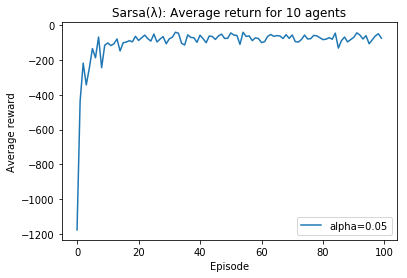

In [32]:
plt.plot(all_rewards, label='alpha=0.05')
#plt.plot(all_rewards_001, label='alpha=0.01')
plt.title("Sarsa(λ): Average return for "+ str(n_agents) + " agents")
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.legend()
plt.show()

Please make sure that all of your code is above this cell. Here, please insert your static learning curve and answer the verbal questions (describe your choice of parameters and results). 

### Answer

I have based my parameter choices on the following diagram from the 2nd edition of Sutton & Barto's textbook. The average number of steps per episode is lowest for an alpha value of 0.125 (1/8) and a lambda value of 0.92. I have also set epsilon to 0 because there is sufficient exploration already as a result of initialising the Q values to zero (zero is optimistic as all true values are negative). The gamma value has been set to 1 so no discounting occurs.

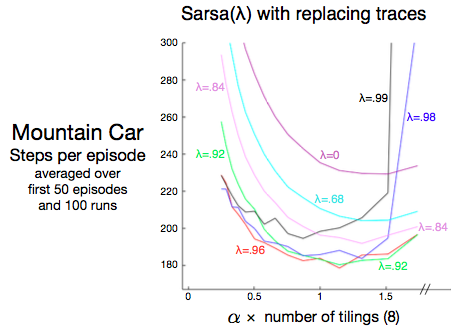



## Part 2 (50 marks)


In [82]:
def play_rbf(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.05, lambda_=0.9, plot=False):

    theta = np.zeros(3000)
    
    reward_per_episode = np.zeros(num_episodes)
    steps_per_episode = np.zeros(num_episodes)
    
    # Create tilings
    tilings = createTiling()
    
    for episode in range(num_episodes):
        
        cumulative_reward = 0
        step = 0

        e = np.zeros(3000)
        env.reset()
        
        # Get starting state and action
        state = np.array([env.position, env.velocity])
        action = random.choice(env.actions)
        
        while not env.game_over:
            
            phi = calcPhi(state, action, tilings)
            
            # Eligibility traces
            x = np.argwhere(phi==1)
            for i in x:
                index = np.asscalar(i)
                #e[i] = 1 # Accumulating traces
                e[index] = 1 # Replacing traces
            
            # Make step and get reward and next state
            reward = env.make_step(action)
            state_ = np.array([env.position, env.velocity])
            
            # Calculate Q and then TD error
            Qa = calcQa(phi, theta)
            #print(Qa)
            delta = reward - Qa
            
            # Epsilon greedy next action choice
            if np.random.uniform(0, 1) < (1 - epsilon):
                action_, Qa_ = e_greedy_action_rbf(theta, state_, env.actions, tilings)
            else:
                action_ = random.choice(env.actions)
                phi = calcPhi(state_, action, tilings)
                Qa_ = calcQ(phi, theta)
            
            # Update delta, theta and e
            delta = delta + gamma * Qa_
            theta = theta + alpha * delta * e
            #print(max(theta))
            e = gamma * lambda_ * e
            
            # Set s = s' and a = a'
            state = np.copy(state_)
            action = action_
            
            # Increment step counter and cumulative reward
            step += 1
            cumulative_reward += reward
            
            # Plot graph if plot boolean on
            if plot == True:
                env.plot()
                
        reward_per_episode[episode] = cumulative_reward
        steps_per_episode[episode] = step
    
    print("complete")
    return reward_per_episode, steps_per_episode
            

In [83]:
def e_greedy_action_rbf(theta, s, actions, tilings):
        Q = np.zeros(3)
        for a in actions:
            phi = calcPhi(s, a, tilings)
            Qa = calcQa(phi, theta)
            Q[a + 1] = Qa
        maxQ = max(Q)
        if (Q == maxQ).sum() > 1:
            best = [i for i in range(len(actions)) if Q[i] == maxQ]
            i = random.choice(best)
        else:
            i = np.argmax(Q)
        action = actions[i]
        Qa = Q[i]
        return action, Qa

In [84]:
def calcQa(phi, theta):
    Qa = np.dot(theta.T, phi)
    return Qa

In [85]:
def calcPhi(state, action, tilings):
    position = np.array(state[0])
    velocity = np.array(state[1])
    
    action_index = action + 1
    
    num_tilings = len(tilings)
    tiling_length = 10
    tiling_height = 10
    num_tiles = num_tilings * tiling_length * tiling_height
    
    #tiles = np.zeros(10, dtype=np.intp)
    phi = np.zeros(3000)
    for a in range(3):
        for t in range(num_tilings):
            xs = tilings[t][0]
            ys = tilings[t][1]
            xi = np.digitize(position, xs)
            yi = np.digitize(velocity, ys)
            c = np.array([xi, yi])
            for y in range(tiling_height):
                for x in range(tiling_length):
                    index = (a * num_tiles) + (t * tiling_length * tiling_height) + x + (y * tiling_height)
                    if a == action_index:
                        s = np.array([x, y])
                        phi[index] = np.exp(-(np.linalg.norm(s - c)) ** 2 / 2)
                    else:
                        phi[index] = 0
        
    return phi

#phi = calcPhi(state, 0, tilings)
#print(state)
#print(np.min(phi))
#test = np.argwhere(phi==1)
#i = test[0]
#print(np.asscalar(i))

In [ ]:
n_agents = 1
num_episodes = 100
all_rewards_rbf = np.zeros(num_episodes)
all_steps_rbf = np.zeros(num_episodes)
for i in range(n_agents):
    env = mountaincar.MountainCar()
    rewards, steps = play_rbf(env, num_episodes, alpha=0.125, gamma=1.0, epsilon=0.0, lambda_=0.92, plot=False)
    all_rewards_rbf += rewards
    all_steps_rbf += steps

all_rewards_rbf = all_rewards_rbf / n_agents
all_steps_rbf = all_steps_rbf / n_agents

In [ ]:
plt.plot(all_rewards, label='Binary')
plt.plot(all_rewards_rbf, label='RBF')
plt.title("Sarsa(λ): Average return for "+ str(n_agents) + " agents")
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.legend()
plt.show()

Please make sure that all of your code is above this cell. Please insert a static learning curve, showing the performance of your learning over time, and answer the questions provided on the coursework specification. Instead of providing your answer here, in this Jupyter notebook, you have the option to provide your answers on a separate pdf document, not exceeding two pages in length. If you do so, please write "Answer in pdf file." in this cell.  

YOUR ANSWER HERE

